In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
from datetime import datetime

import tensorflow as tf
import math
import keras
from keras.callbacks import TensorBoard
import numpy as np
import pandas as pd
from sklearn.utils import class_weight
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix 
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from tensorflow.keras.models import load_model

In [3]:
filepath = r"Set\Model\Path\h5"

## Find best model

In [4]:
files = [f for f in os.listdir(filepath) if os.path.isfile(os.path.join(filepath, f))]
files = [f for f in files if os.path.splitext(f)[-1] == ".h5"]

onlyfiles = dict(map(lambda x: x.replace(".h5", "").replace("MLP_", "").split("-"), files))
bestModel = list(dict(sorted(onlyfiles.items(), key=lambda item: item[1])).keys())[-1]

bestModel = "MLP_" + bestModel + "-" + onlyfiles[bestModel] +".h5"
filepath = os.path.join(filepath, bestModel)

print('best model is', bestModel, 'store at', filepath)

best model is MLP_2861-0.82443821.h5 store at C:\Work\Projets\Titanic\MLP Test\2021-03-20 21-39-34-811858\MLP_2861-0.82443821.h5


In [5]:
model = load_model(filepath=filepath, compile=True)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
h0 (Dense)                   (None, 149)               22350     
_________________________________________________________________
activation (Activation)      (None, 149)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 149)               596       
_________________________________________________________________
dropout (Dropout)            (None, 149)               0         
_________________________________________________________________
h1 (Dense)                   (None, 74)                11100     
_________________________________________________________________
activation_1 (Activation)    (None, 74)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 74)                2

# Load Data file

In [6]:
dataFile = os.path.join(os.path.dirname(filepath), 'Preprocess Data Dummies.xlsx')
print('Existing Data File:', True if os.path.exists(dataFile) else False)

Existing Data File: True


In [7]:
dataframe: pd.DataFrame = pd.read_excel(dataFile, header=[0])
dataframe_submission: pd.DataFrame = pd.read_excel(dataFile, header=[0])
dataframe_submission = dataframe_submission.set_index('PassengerId')
dataframe_submission = dataframe_submission.sort_index(ascending=True)

dataframe = dataframe.set_index('PassengerId')
dataframe = dataframe.sort_index(ascending=True)
dataframe.head(2)

Pclass_1  Pclass_2  Pclass_3  Cabin_A  Cabin_B  Cabin_C  Cabin_D  \
PassengerId                                                                     
1                   0         0         1        0        0        0        0   
2                   1         0         0        0        0        1        0   

             Cabin_E  Cabin_F  Cabin_G  ...  Parch_1  Parch_2  Parch_3  \
PassengerId                             ...                              
1                  0        0        0  ...        0        0        0   
2                  0        0        0  ...        0        0        0   

             Parch_4  Parch_5  Parch_6  Parch_9      Fare  Dataset  Survived  
PassengerId                                                                   
1                  0        0        0        0  0.014151    train       0.0  
2                  0        0        0        0  0.139136    train       1.0  

[2 rows x 151 columns]

In [8]:
original_dataframe: pd.DataFrame = pd.read_excel(os.path.join(os.getcwd(), 'Data', 'Dataset.xlsx'), header=[0])
original_dataframe = original_dataframe.set_index('PassengerId')
original_dataframe = original_dataframe.sort_index(ascending=True)

In [9]:
original_dataframe_test = original_dataframe[dataframe['Dataset'] == 'test']

In [10]:
original_dataframe_train = original_dataframe[dataframe['Dataset'] == 'train']

In [11]:
original_dataframe_validation = original_dataframe[dataframe['Dataset'] == 'validation']
original_dataframe_validation.head(1)

Pclass First Name             Name Civility     Sex  Age  SibSp  \
PassengerId                                                                    
11                3  Sandstrom   Marguerite Rut     Miss  female  4.0      1   

             Parch   Ticket  Fare  Log Fare Cabin Embarked Dataset  Survived  \
PassengerId                                                                    
11               1  PP 9549  16.7  1.222716    G6        S   train       1.0   

             Log Fare Min Max  
PassengerId                    
11                   0.451262

## Define train and test set

In [12]:
dataframe_train: pd.DataFrame = dataframe[dataframe['Dataset'] == 'train']
dataframe_test: pd.DataFrame = dataframe[dataframe['Dataset'] == 'test']
dataframe_validation: pd.DataFrame = dataframe[dataframe['Dataset'] == 'validation']

x_train: pd.DataFrame = dataframe_train.drop(['Survived', 'Dataset'], axis=1, inplace=False)
y_train: pd.DataFrame = dataframe_train['Survived']
    
x_validation: pd.DataFrame = dataframe_validation.drop(['Survived', 'Dataset'], axis=1, inplace=False)
y_validation: pd.DataFrame = dataframe_validation['Survived']  
    
x_test: pd.DataFrame = dataframe_test.drop(['Dataset', 'Survived'], axis=1, inplace=False)

# Results on train set

In [13]:
with tf.device('/cpu:0'):
    predictions_train = model.predict(x_train)
    
original_dataframe_train['Survived Pred Original'] = predictions_train

In [14]:
predictions_train[predictions_train >= 0.5] = 1
predictions_train[predictions_train < 0.5] = 0
predictions_train = predictions_train.reshape(1, -1)[0]
predictions_train = predictions_train.astype('int8')

print('Prediction in train set')
original_dataframe_train['Survived Pred'] = predictions_train
original_dataframe_train[['Sex', 'Survived Pred', 'Survived']].groupby(['Sex']).mean()

Prediction in train set


Survived Pred  Survived
Sex                            
female       0.832031  0.738281
male         0.078947  0.184211

Accuracy train set: 0.8932584269662921
f1 score: 0.8544061302681992


<AxesSubplot:>

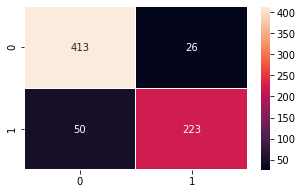

In [15]:
print('Accuracy train set:' , accuracy_score(y_train, predictions_train))
print('f1 score:', f1_score(y_train, predictions_train))
plt.figure(figsize = (5, 3))
sns.heatmap(confusion_matrix(y_train, predictions_train), linewidths = 0.1, linecolor = 'white', annot = True, fmt = 'd')

<AxesSubplot:xlabel='Error'>

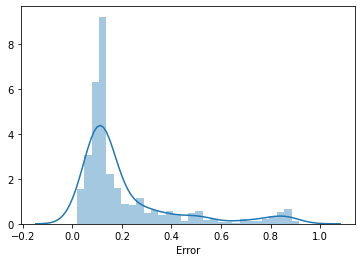

In [16]:
original_dataframe_train['Error'] = np.abs(original_dataframe_train['Survived Pred Original'] - original_dataframe_train['Survived'])
sns.distplot(original_dataframe_train['Error'].sort_values())

# Results on validation set

In [17]:
with tf.device('/cpu:0'):
    predictions_validation = model.predict(x_validation)
    
original_dataframe_validation['Survived Pred Original'] = predictions_validation

In [18]:
predictions_validation[predictions_validation >= 0.5] = 1
predictions_validation[predictions_validation < 0.5] = 0
predictions_validation = predictions_validation.reshape(1, -1)[0]
predictions_validation = predictions_validation.astype('int8')

print('Prediction in validation set')
original_dataframe_validation['Survived Pred'] = predictions_validation
original_dataframe_validation[['Sex', 'Survived Pred', 'Survived']].groupby(['Sex']).mean()

Prediction in validation set


Survived Pred  Survived
Sex                            
female       0.862069  0.758621
male         0.082645  0.206612

Accuracy train set: 0.8044692737430168
f1 score: 0.7286821705426356


<AxesSubplot:>

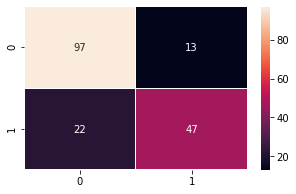

In [19]:
print('Accuracy train set:' , accuracy_score(y_validation, predictions_validation))
print('f1 score:', f1_score(y_validation, predictions_validation))
plt.figure(figsize = (5, 3))
sns.heatmap(confusion_matrix(y_validation, predictions_validation), linewidths = 0.1, linecolor = 'white', annot = True, fmt = 'd')

# Results on Test set

In [20]:
print('Proportion of survivor in test set')
with tf.device('/cpu:0'):
    predictions = model.predict(x_test)
    
predictions[predictions >= 0.5] = 1
predictions[predictions < 0.5] = 0
predictions = predictions.reshape(1, -1)[0]
predictions = predictions.astype('int8')
original_dataframe_test['Survived'] = predictions
original_dataframe_test[['Sex', 'Survived']].groupby(['Sex']).mean()

Proportion of survivor in test set


Survived
Sex             
female  0.894737
male    0.082707

In [21]:
original_dataframe_train['diff'] = np.where(original_dataframe_train['Survived Pred'] == original_dataframe_train['Survived'], True, False)

In [22]:
original_dataframe_train[['Sex', 'Survived', 'Survived Pred']][original_dataframe_train['diff'] == False].groupby(['Sex']).sum()

Survived  Survived Pred
Sex                            
female       1.0             25
male        49.0              1

## Save submission file

In [23]:
dataframe_submission = pd.DataFrame({'PassengerId': dataframe_submission[dataframe_submission['Dataset'] == 'test'].index,
                                     'Survived': predictions})

Submission_file = os.path.join(os.path.dirname(filepath), 'Submission_file.csv')
dataframe_submission.to_csv(Submission_file, index=False)